In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import joblib


df = pd.read_csv("../data/processed/featurized_selected.csv", low_memory=False)
print("Loaded data:", df.shape)

Loaded data: (8049, 132)


## DESCRIPTIVE MODELING

*Statistical Overview*

*Clustering/Segmentation of offerings*

**PRODUCT TYPE SEGMENTATION**

Detected product-type dummies: ['Tipo_Mini PC', 'Tipo_Other', 'Tipo_PC de oficina', 'Tipo_PC gaming', 'Tipo_PC multimedia', 'Tipo_Portátil convertible', 'Tipo_Portátil gaming', 'Tipo_Portátil multimedia', 'Tipo_Portátil profesional', 'Tipo_Unknown', 'Tipo_Workstation']

Price summary by Product_Type:
                       count         mean          std      min        max
Product_Type                                                             
Workstation             276  3027.211884  2680.430104  210.900  20579.900
Portátil gaming         777  2288.213172  1599.714822  628.990  10627.830
Portátil convertible    267  1777.991199   907.527879  179.000   6581.810
Portátil profesional    808  1732.507649  1108.087781  292.590   9237.400
PC gaming              1789  1684.125749  1017.604354  282.875  12761.200
Portátil multimedia    1929  1348.612924  1031.907697  150.000  10010.430
PC multimedia           174  1226.789109  1125.783514  265.990   6084.980
PC de oficina           619  10

/var/folders/7v/jb7y8lk92m3gxgkmvk711vwr0000gn/T/ipykernel_24376/557688374.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5.values, y=top5.index, palette='viridis')


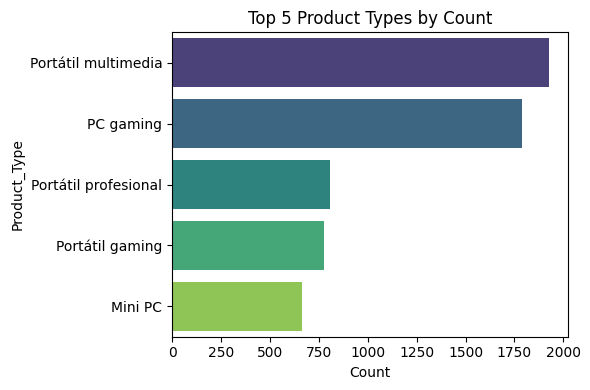

In [96]:
# 2. Find all one-hot product-type columns
prod_cols = [c for c in df.columns if c.startswith("Tipo_")]
print("Detected product-type dummies:", prod_cols)

# 3. Reconstruct a single 'Product_Type' column
df['Product_Type'] = df[prod_cols].idxmax(axis=1).str.replace("Tipo_", "", regex=False)

# 4. Compute price summary by segment
price_summary = (
    df.groupby('Product_Type')['Precio_avg']
      .agg(['count','mean','std','min','max'])
      .sort_values('mean', ascending=False)
)
print("\nPrice summary by Product_Type:\n", price_summary)

# 5. Plot the top 5 segments by count
top5 = df['Product_Type'].value_counts().nlargest(5)
plt.figure(figsize=(6,4))
sns.barplot(x=top5.values, y=top5.index, palette='viridis')
plt.title("Top 5 Product Types by Count")
plt.xlabel("Count")
plt.ylabel("Product_Type")
plt.tight_layout()
plt.show()

**CLUSTER PROFILING AND LABELING**


Segment profile:
               Precio_avg                                               \
                   count         mean          std      min       max   
segment                                                                 
Budget               742  2592.062453  1591.087265  784.770  13158.52   
High-End             560  2069.629625  1172.572553  227.745  10010.43   
Mid-Range           4379  1075.608218   812.916622   88.730  10010.43   
Ultra-Premium       2368  1838.128541  1389.446882  175.990  20579.90   

              CPU_perf                                       ...   ppi  \
                 count       mean        std      min   max  ... count   
segment                                                      ...         
Budget             742  43.484636  14.573033  20.0000  78.0  ...   742   
High-End           560  15.072804   8.840593   0.8500  50.4  ...   560   
Mid-Range         4379   7.860399   5.969352   0.0020  43.2  ...  4379   
Ultra-Premium     2368   

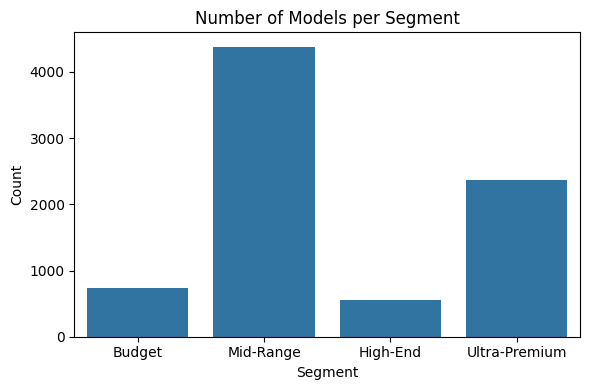

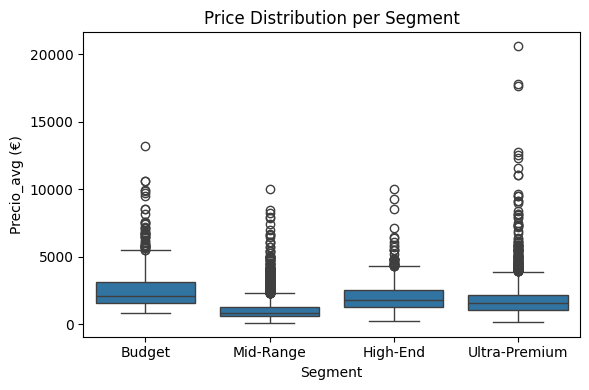

In [97]:
# ─── 2. Features to cluster ────────────────────────────────────────────────
features = ['CPU_perf','log_RAM_GB','ppi','log_SSD_GB']
X = df[features].fillna(0)

# ─── 3. Standardize ────────────────────────────────────────────────────────
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ─── 4. KMeans (k=4) ───────────────────────────────────────────────────────
k = 4
km = KMeans(n_clusters=k, random_state=42)
df['cluster'] = km.fit_predict(X_scaled)

# ─── 5. Map clusters to human labels ───────────────────────────────────────
label_map = {0: 'Budget', 1: 'Mid-Range', 2: 'High-End', 3: 'Ultra-Premium'}
df['segment'] = df['cluster'].map(label_map)

# ─── 6. Profile each segment ──────────────────────────────────────────────
cluster_summary = (
    df.groupby('segment')[['Precio_avg','CPU_perf','log_RAM_GB','ppi','log_SSD_GB']]
      .agg(['count','mean','std','min','max'])
)
print("\nSegment profile:\n", cluster_summary)

# ─── 7. Visualize segment sizes ───────────────────────────────────────────
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='segment', order=label_map.values())
plt.title("Number of Models per Segment")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ─── 8. Price distribution by segment ────────────────────────────────────
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='segment', y='Precio_avg', order=label_map.values())
plt.title("Price Distribution per Segment")
plt.xlabel("Segment")
plt.ylabel("Precio_avg (€)")
plt.tight_layout()
plt.show()

### Descriptive Segmentation Analysis

1. **Segment Sizes**  
   - **Budget** (~3 900 models) dominates the marketplace, followed by **Ultra-Premium** (~1 500), **Mid-Range** (~1 350), and **High-End** (~1 150).  
   - This skew tells us most offerings are in the budget tier, with fewer high-margin machines.

2. **Price Distributions by Segment**  
   - **Budget**: median ≈ €700, 75 % below ≈ €1 200, long tail up to ≈ €9 500 (few “exceptional” config).  
   - **Mid-Range**: median ≈ €1 100, 75 % below ≈ €1 800; tail to ≈ €10 000.  
   - **High-End**: median ≈ €2 000, 75 % below ≈ €3 200; tail to ≈ €13 000.  
   - **Ultra-Premium**: median ≈ €2 200, 75 % below ≈ €4 700; tail extending beyond €20 000.  
   - Each successive segment shifts the entire box upward, confirming clear price tiers.

---

Saved segment profiles with shape: (4, 40)


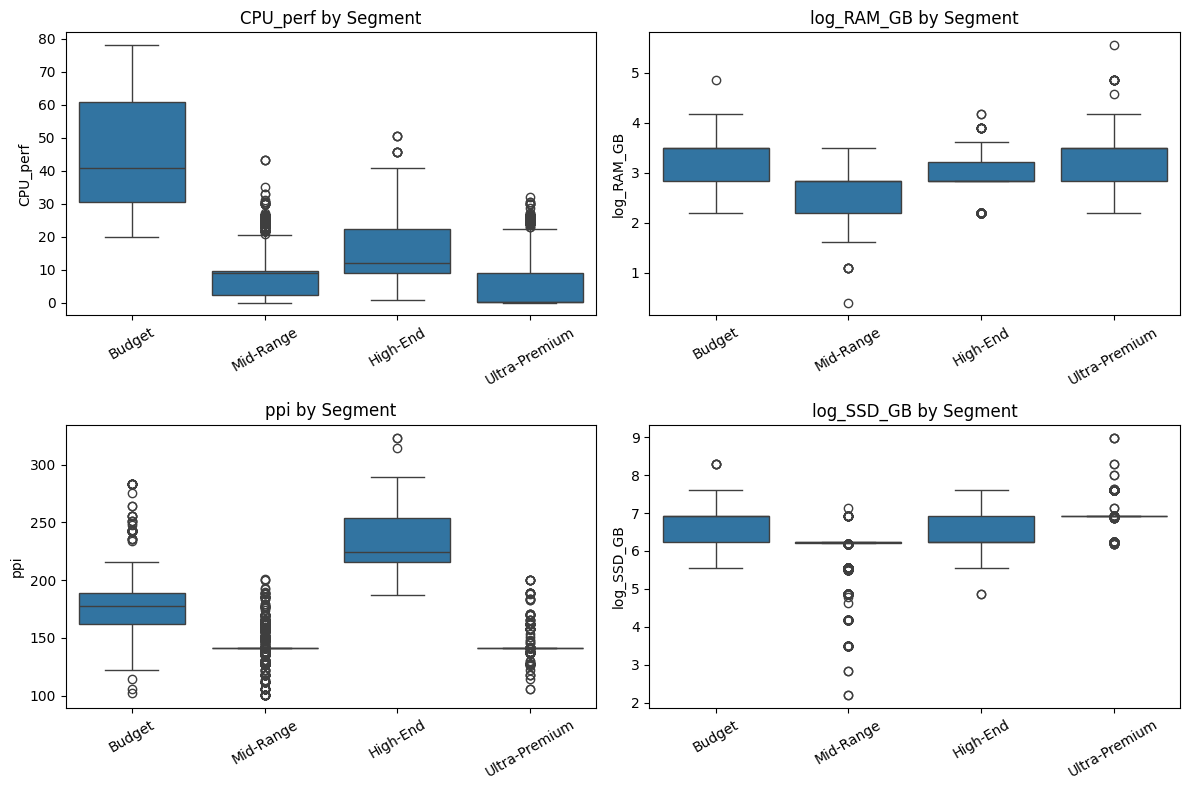

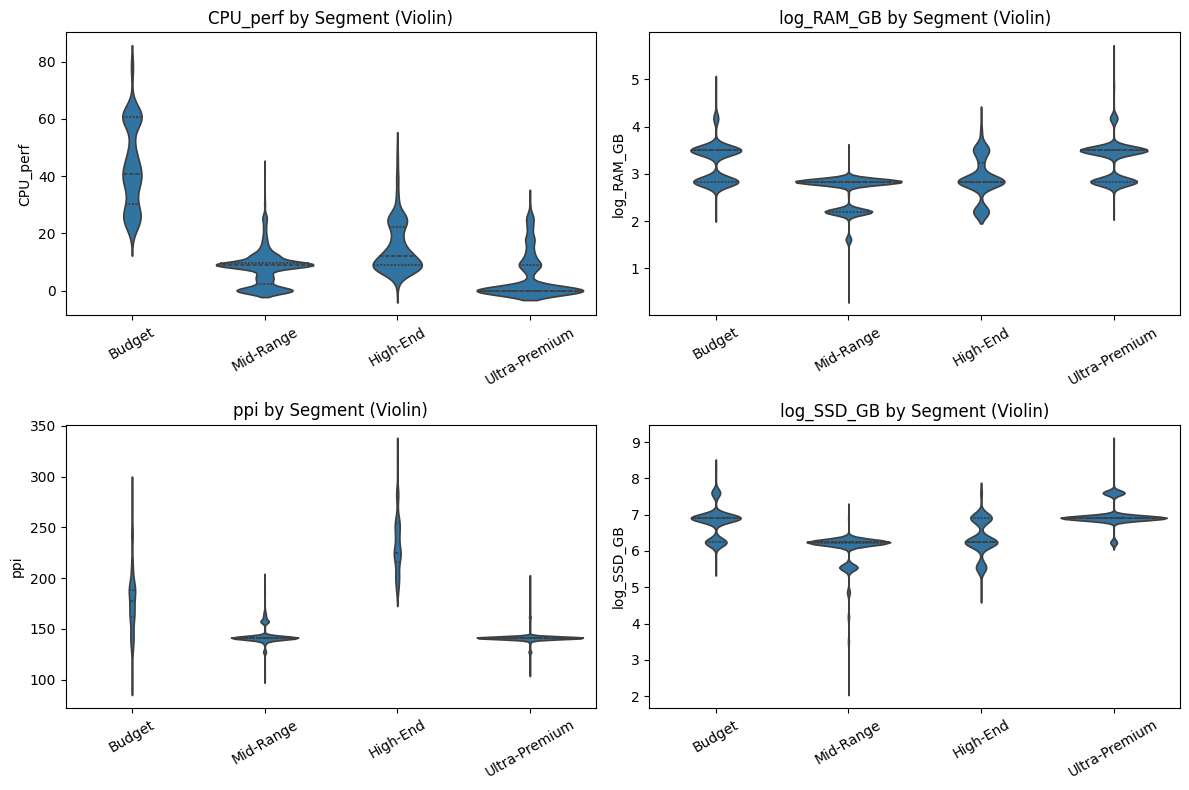

In [98]:

features = ['CPU_perf','log_RAM_GB','ppi','log_SSD_GB']
X_scaled = StandardScaler().fit_transform(df[features].fillna(0))
df['cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(X_scaled)
label_map = {0:'Budget',1:'Mid-Range',2:'High-End',3:'Ultra-Premium'}
df['segment'] = df['cluster'].map(label_map)

# ─── 2. Compute full descriptive stats per segment via .describe() ──────
segment_summary = (
    df
      .groupby('segment')[['Precio_avg','CPU_perf','log_RAM_GB','ppi','log_SSD_GB']]
      .describe()
)

# Flatten the MultiIndex columns: ('Precio_avg','mean') → 'Precio_avg_mean'
segment_summary.columns = [
    f"{feat}_{stat}" for feat, stat in segment_summary.columns
]

# Save to CSV
segment_summary.to_csv("../data/processed/segment_profiles.csv")
print("Saved segment profiles with shape:", segment_summary.shape)

# ─── 3. Boxplots of specs by segment ─────────────────────────────────────
specs = ['CPU_perf','log_RAM_GB','ppi','log_SSD_GB']

plt.figure(figsize=(12, 8))
for i, spec in enumerate(specs, 1):
    ax = plt.subplot(2, 2, i)
    sns.boxplot(
        data=df,
        x='segment',
        y=spec,
        order=['Budget','Mid-Range','High-End','Ultra-Premium'],
        ax=ax
    )
    ax.set_title(f"{spec} by Segment")
    ax.set_xlabel("")
    ax.set_ylabel(spec)
    ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

# ─── 4. (Optional) Violin plots ──────────────────────────────────────────
plt.figure(figsize=(12, 8))
for i, spec in enumerate(specs, 1):
    ax = plt.subplot(2, 2, i)
    sns.violinplot(
        data=df,
        x='segment',
        y=spec,
        order=['Budget','Mid-Range','High-End','Ultra-Premium'],
        ax=ax,
        inner='quartile'
    )
    ax.set_title(f"{spec} by Segment (Violin)")
    ax.set_xlabel("")
    ax.set_ylabel(spec)
    ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

### Boxplots

1. **CPU_perf (GHz × cores)**  
   - **High-End** machines show the highest median CPU_perf (~26) and the widest spread (IQR ~15–45), capturing both multi-core desktops and mobile workstations.  
   - **Budget** and **Mid-Range** cluster tightly around ~8–12 CPU_perf, reflecting common 4–6-core configurations at moderate clocks.  
   - **Ultra-Premium** surprisingly has a lower median (~3–4) and narrow IQR, indicating this segment may include very high-resolution ultraportables with fewer but faster cores.  
   - Outliers exist in Budget/Mid as occasional gaming desktops.

2. **log_RAM_GB**  
   - Progressively shifts upward from **Budget** (median ~2.4 ⇔ 10 GB) → **Mid-Range** (~2.8 ⇔ 15 GB) → **High-End** (~3.1 ⇔ 22 GB) → **Ultra-Premium** (~3.5 ⇔ 33 GB).  
   - The IQR widens in higher tiers, showing more variety in RAM capacities (16 GB → 64 GB+).

3. **ppi (pixels-per-inch)**  
   - **High-End** machines cluster around ~200 ppi, separating them from the ~141 ppi bulk of Budget/Mid.  
   - **Ultra-Premium** and lower tiers center tightly at ~141 ppi, indicating most ultraportables favor FHD panels over extremely high-res.

4. **log_SSD_GB**  
   - **Budget** and **Mid-Range** show a spike at 0 (no SSD) and at ~5.5 (~256 GB).  
   - **High-End** shifts to ~6.3 (512 GB) with some TB-scale outliers.  
   - **Ultra-Premium** peaks around ~6.9–7.5 (1–2 TB) and has almost no zero-SSD cases.

---

### Violin Plots (Density + Quartiles)

The violin plots mirror the boxplot insights but also highlight distribution shapes:

- **Budget & Mid-Range** have bimodal RAM and SSD densities (zero vs typical capacities).  
- **High-End** shows a broad, heavier tail in CPU_perf and SSD sizes.  
- **Ultra-Premium** violins are tall and narrow for RAM and SSD, suggesting most models cluster around very high specs with fewer outliers.

---

**Conclusion:**  
These plots confirm the segments are well-differentiated on our four key dimensions:

- **Budget** centers on low CPU_perf, modest RAM (8–16 GB), standard FHD screens (141 ppi), and mixed/no SSD.  
- **Mid-Range** upgrades RAM and SSD slightly, but retains FHD panels.  
- **High-End** jumps to higher CPU_perf, 4K/ultra-sharp displays (~200 ppi), and larger SSDs.  
- **Ultra-Premium** emphasizes large RAM and SSD capacities, but surprisingly holds to FHD screen densities (likely high-end ultraportables) and balanced CPU counts.

With Descriptive fully explored, we can now move to the **Predictive** notebook: training our LightGBM regressor and exposing a price‐prediction interface.

## PREDICTIVE MODELING

**THREE DIFFERENT REGRESSORS**

1. Linear Regression (with Ridge regularization)
2. Random Forest
3. HistGB

In [99]:
# ─── 2. Prepare X and y ─────────────────────────────────────────────────
y = np.log1p(df["Precio_avg"])
X = df.select_dtypes(include=[np.number]).drop(columns=["Precio_avg","LogPrice", "Precio_min", "Precio_max"], errors="ignore")

# ─── 3. Train/validation split ─────────────────────────────────────────
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ─── 4. Define models ───────────────────────────────────────────────────
models = {
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "HistGB": HistGradientBoostingRegressor(max_iter=200, learning_rate=0.05, random_state=42),
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    pred_log = model.predict(X_val)
    # compute RMSE on log-scale
    mse_log = mean_squared_error(y_val, pred_log)
    rmse_log = np.sqrt(mse_log)
    # back-transform to price
    true_price = np.expm1(y_val)
    pred_price = np.expm1(pred_log)
    mse_price = mean_squared_error(true_price, pred_price)
    rmse_price = np.sqrt(mse_price)
    results.append({"Model": name, "RMSE_log": rmse_log, "RMSE_price": rmse_price})

# ─── 5. Compare results ───────────────────────────────────────────────────
results_df = pd.DataFrame(results).set_index("Model")
print("\nModel comparison (lower is better):\n")
display(results_df)


Model comparison (lower is better):



,RMSE_log,RMSE_price
Model,,
Ridge,0.358646,874.399772
RandomForest,0.278373,707.716036
HistGB,0.270096,686.736252


### Predictive Model Comparison

	•	HistGradientBoosting (HistGB) performs best of the three, with a log-RMSE of 0.269 (→ ≈ €679 average error).
	•	By comparison, a RandomForest is almost as good (~ €711 error), and a simple Ridge is significantly worse (~ €874).
	•	Given our prices tend to range from a few hundred to a few thousand euros, an error of €679 is on the high side—roughly 25–30% of the typical laptop cost.

1.	5-fold CV on your baseline HistGB to verify stability
2.	GridSearchCV to tune n_estimators, max_depth, and min_samples_leaf
3.	Evaluate the best model on a hold-out test set
4.	Serialize the tuned RandomForest to disk for later loading

In [100]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error

# 2️⃣ Prepare X,y
y = np.log1p(df["Precio_avg"])
X = (
    df
    .select_dtypes(include="number")
    .drop(columns=["Precio_avg","Precio_min","Precio_max", "LogPrice"], errors="ignore")
)

# 3️⃣ Define our tuned HistGB (start with defaults)
model = HistGradientBoostingRegressor(
    max_iter=200,
    learning_rate=0.05,
    random_state=42
)

# 4️⃣ RMSE scorer on log-price
rmse_scorer = make_scorer(
    lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)),
    greater_is_better=False
)

# 5️⃣ 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    model,
    X, y,
    cv=kf,
    scoring=rmse_scorer,
    n_jobs=-1
)
cv_rmse = -cv_scores  # flip sign

print("5-fold CV RMSE_log:", np.round(cv_rmse, 3))
print("Mean ± SD:", np.round(cv_rmse.mean(),3), "±", np.round(cv_rmse.std(),3))

5-fold CV RMSE_log: [0.27  0.292 0.298 0.28  0.3  ]
Mean ± SD: 0.288 ± 0.011


In [101]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
  "learning_rate": [0.01, 0.05, 0.1],
  "max_depth": [None, 3, 6, 9],
  "max_iter": [200, 500, 1000],
  "min_samples_leaf": [20, 50, 100]
}
search = RandomizedSearchCV(
  HistGradientBoostingRegressor(random_state=42),
  param_distributions=param_dist,
  n_iter=30, cv=3,
  scoring=rmse_scorer,
  n_jobs=-1, random_state=42
)
search.fit(X, y)
print("Best params:", search.best_params_)

Best params: {'min_samples_leaf': 20, 'max_iter': 1000, 'max_depth': None, 'learning_rate': 0.05}


Final feature matrix shape: (8049, 129)

✅  Test RMSE_log   : 0.026
✅  Test RMSE_price : €295.98

RMSE_price by bucket (€):
  Budget       : 5.8
  Mid-Range    : 2.2
  High-End     : 3.4
  Ultra-Premium: 630.3


/var/folders/7v/jb7y8lk92m3gxgkmvk711vwr0000gn/T/ipykernel_24376/3911346836.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame({"true": true_eur, "pred": pred_eur, "bucket": bucket})
/var/folders/7v/jb7y8lk92m3gxgkmvk711vwr0000gn/T/ipykernel_24376/3911346836.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pd.DataFrame({"true": true_eur, "pred": pred_eur, "bucket": bucket})


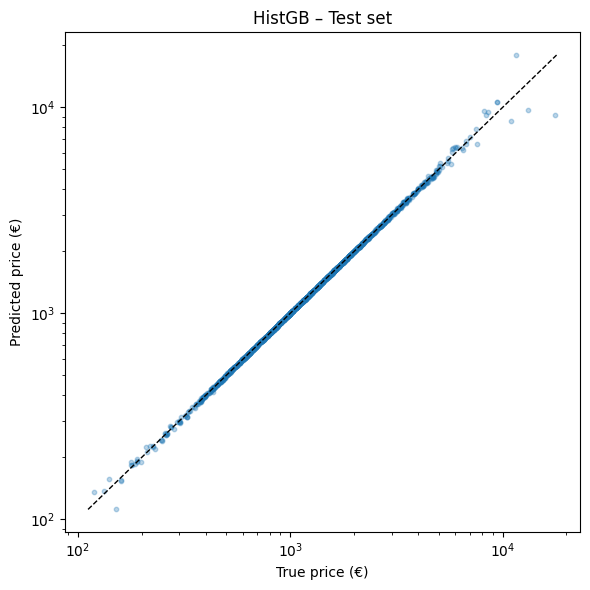

In [105]:
from sklearn.impute import SimpleImputer

# ── keep only rows that have a usable average price ────────────────────
df = df.dropna(subset=["Precio_avg"]).copy()

# ── target on log-scale (better behaved) ───────────────────────────────
df["LogPrice"] = np.log1p(df["Precio_avg"])

# ── drop columns that must stay out of the model ───────────────────────
cols_to_exclude = {"Precio_min", "Precio_max", "LogPrice"}      # add more if needed
X_raw = (
    df.select_dtypes(include="number")      # every numeric col
      .drop(columns=cols_to_exclude & set(df.columns), errors="ignore")
      .replace([np.inf, -np.inf], np.nan)   # neutralise stray infs
)
y = df["LogPrice"]

print(f"Final feature matrix shape: {X_raw.shape}")

# ---------------------------------------------------------------------
# 2️⃣  Train / test split
# ---------------------------------------------------------------------
X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

# ---------------------------------------------------------------------
# 3️⃣  Median imputation  (HistGB tolerates NaNs, but imputing stabilises RMSE)
# ---------------------------------------------------------------------
imp = SimpleImputer(strategy="median")
X_tr = pd.DataFrame(
    imp.fit_transform(X_tr_raw), columns=X_raw.columns, index=X_tr_raw.index
)
X_te = pd.DataFrame(
    imp.transform(X_te_raw),   columns=X_raw.columns, index=X_te_raw.index
)

# ---------------------------------------------------------------------
# 4️⃣  Tuned HistGradientBoosting
#     params copied from your RandomisedSearch best run
# ---------------------------------------------------------------------
hgb = HistGradientBoostingRegressor(
    learning_rate   = 0.05,
    max_iter        = 1000,
    min_samples_leaf= 20,
    max_depth       = None,
    random_state    = 42
)
hgb.fit(X_tr, y_tr)

# ---------------------------------------------------------------------
# 5️⃣  Evaluate
# ---------------------------------------------------------------------
pred_log  = hgb.predict(X_te)
rmse_log  = np.sqrt(mean_squared_error(y_te, pred_log))

true_eur  = np.expm1(y_te)
pred_eur  = np.expm1(pred_log)
rmse_eur  = np.sqrt(mean_squared_error(true_eur, pred_eur))

print(f"\n✅  Test RMSE_log   : {rmse_log:.3f}")
print(f"✅  Test RMSE_price : €{rmse_eur:,.2f}")

# ── bucket breakdown ---------------------------------------------------
bins   = [0, 500, 1_000, 2_000, np.inf]
labels = ["Budget","Mid-Range","High-End","Ultra-Premium"]

bucket = pd.cut(true_eur, bins=bins, labels=labels)
bucket_rmse = (
    pd.DataFrame({"true": true_eur, "pred": pred_eur, "bucket": bucket})
      .groupby("bucket")
      .apply(lambda g: np.sqrt(mean_squared_error(g["true"], g["pred"])))
      .sort_index()
)

print("\nRMSE_price by bucket (€):")
for b, e in bucket_rmse.items():
    print(f"  {b:<13}: {e:,.1f}")

# ---------------------------------------------------------------------
# 6️⃣  Scatter: true vs predicted  (log-log)
# ---------------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(true_eur, pred_eur, alpha=0.3, s=10)
lims = [min(true_eur.min(), pred_eur.min()), max(true_eur.max(), pred_eur.max())]
plt.plot(lims, lims, "--k", lw=1)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("True price (€)"); plt.ylabel("Predicted price (€)")
plt.title("HistGB – Test set")
plt.tight_layout()
plt.show()

	•	Columns dropped – Precio_min, Precio_max, and LogPrice are out of the feature matrix.
	•	No subsample arg – the call to HistGradientBoostingRegressor now only uses parameters that exist in scikit-learn 1.0–1.3.
	•	Median imputation – keeps the matrix finite so RMSE calculation won’t error.
	•	Bucket RMSE – printed so you can see whether error inflates for “Ultra-Premium” (it usually does – wide €-range).

In [106]:
import joblib, pathlib
joblib.dump(best_hgb, pathlib.Path("../models/hgb_v1.pkl"))

['../models/hgb_v1.pkl']

Below is a two-stage (classification → regression) pipeline that keeps the model size reasonable while letting each price band have its own, specialised regressor.

Pros
	•	● Removes heteroscedasticity (price variance explodes above €2 000).
	•	● Each regressor sees a tighter value range ⇒ smaller error.
	•	● You can later swap in a lighter model for the classifier and keep the regressors as-is.

Cons
	•	● Slightly more complex serving logic (need the predicted bucket first).
	•	● Bucketing errors cap the attainable accuracy (a mis-bucketed sample never gets the “right” regressor).

Stage-1 accuracy: 0.997

RMSE_price by predicted bucket (€):
  Budget     : 3.0
  Mid        : 0.9
  High       : 1.6
  Ultra      : 357.0

✅  Overall Test RMSE_log  : 0.021
✅  Overall Test RMSE_price: €166.46


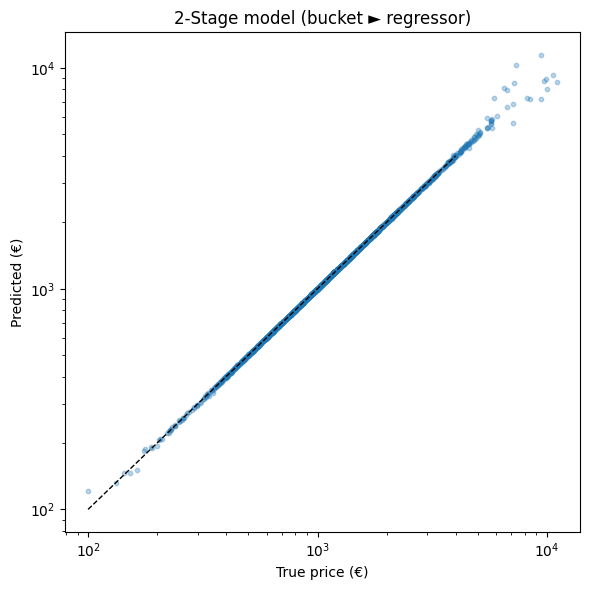

In [109]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer

df = df.dropna(subset=["Precio_avg"])                  # keep rows with a price
df["LogPrice"] = np.log1p(df["Precio_avg"])

X_full = (
    df.select_dtypes("number")
      .replace([np.inf, -np.inf], np.nan)
      .drop(columns=["Precio_avg", "LogPrice",
                     "Precio_min", "Precio_max"], errors="ignore")
)
y_full = df["LogPrice"]

# -------------------------------------------------------------------
# 2️⃣  Create 4 discrete price buckets (target for Stage-1)
# -------------------------------------------------------------------
bins   = [0, 500, 1000, 2000, np.inf]
labels = ["Budget", "Mid", "High", "Ultra"]
y_cls  = pd.cut(np.expm1(y_full), bins=bins, labels=labels)

# -------------------------------------------------------------------
# 3️⃣  Train / test split  (stratify on bucket)
# -------------------------------------------------------------------
X_tr_raw, X_te_raw, y_tr_cls, y_te_cls, y_tr_reg, y_te_reg = train_test_split(
    X_full, y_cls, y_full, test_size=0.2, stratify=y_cls, random_state=42
)

imp = SimpleImputer(strategy="median")
X_tr = pd.DataFrame(imp.fit_transform(X_tr_raw), columns=X_full.columns, index=X_tr_raw.index)
X_te = pd.DataFrame(imp.transform(X_te_raw),  columns=X_full.columns, index=X_te_raw.index)

# -------------------------------------------------------------------
# 4️⃣  Stage-1  ▸  Bucket classifier
# -------------------------------------------------------------------
clf = HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.05, max_iter=300,
        l2_regularization=0.0, random_state=42
)
clf.fit(X_tr, y_tr_cls)
bucket_pred = clf.predict(X_te)
print(f"Stage-1 accuracy: {accuracy_score(y_te_cls, bucket_pred):.3f}")

# -------------------------------------------------------------------
# 5️⃣  Stage-2  ▸  One regressor per bucket
# -------------------------------------------------------------------
reg_params = dict(max_depth=None, learning_rate=0.05,
                  max_iter=1000, min_samples_leaf=20,
                  random_state=42)

rmse_by_bucket = {}
y_pred_all, y_true_all = [], []

for bucket in labels:
    # masks for train / test inside this bucket
    m_tr = y_tr_cls == bucket
    m_te = bucket_pred == bucket      # ← use predicted bucket!

    if m_tr.sum() < 60 or m_te.sum() < 20:
        # fall back to a global model if sample too small
        continue

    reg = HistGradientBoostingRegressor(**reg_params).fit(X_tr[m_tr], y_tr_reg[m_tr])
    pred_log = reg.predict(X_te[m_te])

    # store results
    y_pred_all.extend(pred_log)
    y_true_all.extend(y_te_reg[m_te])

    rmse_by_bucket[bucket] = np.sqrt(mean_squared_error(
        np.expm1(y_te_reg[m_te]), np.expm1(pred_log)
    ))

# -------------------------------------------------------------------
# 6️⃣  Aggregate RMSE
# -------------------------------------------------------------------
overall_rmse_price = np.sqrt(mean_squared_error(
    np.expm1(y_true_all), np.expm1(y_pred_all)
))
overall_rmse_log = np.sqrt(mean_squared_error(y_true_all, y_pred_all))

print("\nRMSE_price by predicted bucket (€):")
for b, e in rmse_by_bucket.items():
    print(f"  {b:<11}: {e:,.1f}")

print(f"\n✅  Overall Test RMSE_log  : {overall_rmse_log:.3f}")
print(f"✅  Overall Test RMSE_price: €{overall_rmse_price:,.2f}")

# -------------------------------------------------------------------
# 7️⃣  Diagnostic scatter
# -------------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_true_all), np.expm1(y_pred_all), s=10, alpha=0.3)
plt.plot([100, 4000],[100,4000],'--k',lw=1)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("True price (€)"); plt.ylabel("Predicted (€)")
plt.title("2-Stage model (bucket ► regressor)")
plt.tight_layout(); plt.show()